# **Fine-Tuning mT5 for Latin Translation & Summarization**

This notebook contains two main parts:

1. **Training mT5** for **English → Latin translation** and **summary extraction**.
2. **Fine-Tuning mT5** for **Latin → Latin summarization**.

---

## **Table of Contents**

### 1. Training mT5 for English → Latin Translation & Summarization
- 1.1 **Load Libraries**
- 1.2 **Define Global Parameters**
- 1.3 **Load Dataset**
- 1.4 **Initialize Model & Tokenizer**
- 1.5 **Training Process**
- 1.6 **Evaluate BLEU & CHRF Score**

### 2. Fine-Tuning mT5 for Latin → Latin Summarization
- 2.1 **Load Libraries**
- 2.2 **Define Global Parameters**
- 2.3 **Load Dataset**
- 2.4 **Initialize Model & Tokenizer**
- 2.5 **Fine-Tuning Process**
- 2.6 **Evaluate ROUGE & BERTScore**
- 2.7 **Grade Summaries with Mistral Model**
- 2.8 **Save Final Model & Results**

---

## **Workflow Overview**
This notebook fine-tunes **mT5**, a multilingual sequence-to-sequence transformer, for two tasks:
1. **English to Latin translation and summarization**: Training on a parallel corpus with structured prompts.
2. **Latin to Latin summarization**: Using extractive summaries for fine-tuning and evaluation.

The process includes:
- **Dataset preparation**: Tokenization, prompt generation, and pretraining corpus setup.
- **Model fine-tuning**: Training mT5 with **LoRA adapters** for efficient tuning.
- **Evaluation metrics**: Computing **BLEU, CHRF, ROUGE, and BERTScore** to measure translation and summarization performance.
- **Summary grading**: Using a **Mistral model** to assess the quality of generated summaries.
- **Final model export**: Saving the trained model for deployment.


# 1. Training mT5 for English → Latin Translation & Summarization

## Load Libraries

In [18]:
import os
import pandas as pd
import numpy as np
import torch
import warnings
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer, get_linear_schedule_with_warmup
from utils.mT5_train import training_loop, plot_training
from utils.bleu import calculate_bleu_and_chrf
from peft import get_peft_model, LoraConfig
from utils.generate_translation import generate_translation, generate_translation_with_options, inference_from_csv, inference_from_csv_adding_column

## <a id="Global-Parameters"></a> Define Global Parameters

In [19]:
# Global parameters for translation training
language1 = "en"
language2 = "la"
path_to_train = "/Data/AxelDlv/LatinSummarizer/prompt_with_stanza_train.csv"
path_to_test = "/Data/AxelDlv/LatinSummarizer/prompt_with_stanza_test.csv"
path_to_special_tokens = "/Data/AxelDlv/LatinSummarizer/stanza_merged_tags_la_en.csv"

max_seq_len = 512
max_new_tokens = 512
model_pretrained = "mt5-small"
model_name = f"/Data/AxelDlv/mt5-small-en-la-translation/{model_pretrained}"  # Adjust as needed
preexisting_checkpoint_path = ""  # Leave empty if not using a previous checkpoint
checkpoint_dir = f"/Data/AxelDlv/mt5-small-en-la-translation"
checkpoint_prefix = "mt5-small-en-la-translation-final_with_stanza"

batch_size = 4
lr = 5e-4
start_epoch = 0
end_epoch = 5

os.makedirs(checkpoint_dir, exist_ok=True)
warnings.filterwarnings("ignore")

print(f"Aiming to train a model to translate and summarize {language2} texts using {language1} as a pivot.")
print(f"Training data: {path_to_train} | Testing data: {path_to_test}")
print(f"Training for {end_epoch} epochs with batch size {batch_size} and learning rate {lr}.")

Aiming to train a model to translate and summarize la texts using en as a pivot.
Training data: /Data/AxelDlv/LatinSummarizer/prompt_with_stanza_train.csv | Testing data: /Data/AxelDlv/LatinSummarizer/prompt_with_stanza_test.csv
Training for 5 epochs with batch size 4 and learning rate 0.0005.


## <a id="Load-Dataset"></a> Load Dataset

We assume that the dataset has been pre-processed in two csv files with columns 'prompt', 'answer', 'prefix'

In [20]:
try:
    df_train = pd.read_csv(path_to_train)
    df_test = pd.read_csv(path_to_test)
except:
    # Give an example of df_train and df_test
    df_train = pd.DataFrame({
        "prefix": ["<en.la>", "<en.la>"],
        "prompt": ["This is a sample text", "This is another sample text"],
        "answer": ["Hic est exemplum", "Hic est aliud exemplum"]
    })
    df_test = pd.DataFrame({
        "prefix": ["<en.la>", "<en.la>"],
        "prompt": ["This is a sample text", "This is another sample text"],
        "answer": ["Hic est exemplum", "Hic est aliud exemplum"]
    })

df_train

,prompt,answer,prefix
0,<la> <no_stanza> rogabis eum et exaudiet te et...,"Thou shalt pray to him, and he will hear thee,...",la.en
1,"<en> <no_stanza> Here I ask, if sufficient pro...","hic quaero, si Hiempsali satis est cautum foe...",en.la
2,<en> <no_stanza> Africans and warlike Spaniard...,"ast hic, tranquillo qua labitur agmine flumen,...",en.la
3,<en> <no_stanza> For who does not realize that...,"Quis est enim qui hoc non intellegat, nisi Cae...",en.la
4,"<la> 9 Sed dicebat, quod aliquis dicitur vider...","9 Sed dicebat, quod aliquis dicitur videre non...",la.la
...,...,...,...
633514,<la> <with_stanza> Duo <NUM> tamen <ADV> agger...,"However <ADV> , <PUNCT> two <NUM> lofty <ADJ> ...",la.en
633515,"<la> O homo, audi et intellige verba illius qu...","O homo, audi et intellige verba illius qui era...",la.la
633516,<en> <with_stanza> And <CCONJ> he <PRON> shall...,et reget illas in virga ferrea tamquam vas fig...,en.la
633517,"<la> ad 7 Ad septimum dicendum, quod duplicite...","ad 7 Ad septimum dicendum, quod dupliciter ali...",la.la


In [21]:
df_test

,prompt,answer,prefix
0,<la> <no_stanza> Aperuerat iam Italiam bellumq...,The road into Italy had already been opened an...,la.en
1,<la> <no_stanza> Usus practicus unus est ad al...,One practical use is for altitude of geopotent...,la.en
2,<la> <with_stanza> praeferunt <VERB> gustandi ...,As if we were not far inferior in this even to...,la.en
3,<en> <no_stanza> But let all things be done de...,omnia autem honeste et secundum ordinem fiant ...,en.la
4,"<la> Affert secundus ramus persicum, ex persic...","Affert secundus ramus persicum, ex persico, et...",la.la
...,...,...,...
33338,"<la> <no_stanza> Sed vos religiosi, qui eam qu...",But it is you who are the really religious peo...,la.en
33339,<la> <no_stanza> ne forte decepti faciatis vob...,"Lest ye corrupt yourselves, and make you a gra...",la.en
33340,<en> <with_stanza> And <CCONJ> thou <PRON> sha...,et diliges Dominum Deum tuum ex toto corde tuo...,en.la
33341,"<la> Hanc fabulam ponit Lucanus: Fuit, inquit,...","Hanc fabulam ponit Lucanus: Fuit, inquit, in L...",la.la


## <a id="Model-and-Tokenizer"></a> Initialize Model & Tokenizer

The special tokens should be stored in a csv file with a column `token`

In [22]:
# Load special tokens and initialize tokenizer
special_tokens = pd.read_csv(path_to_special_tokens)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens['token'].tolist()})

# Load the model and adjust token embeddings
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).cuda()
model.resize_token_embeddings(len(tokenizer))

# for n, _ in model.named_modules():
#     if ".q" in n or ".v" in n:
#         print(n)

# Load pre-existing checkpoint if provided
if preexisting_checkpoint_path and os.path.exists(preexisting_checkpoint_path):
    model.load_state_dict(torch.load(preexisting_checkpoint_path))
    print(f"Loaded checkpoint from: {preexisting_checkpoint_path}")

# Integrate LoRA using PEFT (adjust target modules as needed)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)
print("LoRA integration complete.")

print(f"Special tokens added: {special_tokens['token'].tolist()}")
print(f"Model parameters: {model.num_parameters():,}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}, total tokens: {len(tokenizer)}")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


LoRA integration complete.
Special tokens added: ['<en>', '<la>', '<en.la>', '<la.en>', '<la.la>', '<with_stanza>', '<no_stanza>', '<clue>', '<EMPTY>', '<PAD>', '<ROOT>', '<UNK>', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
Model parameters: 300,530,048
Tokenizer vocab size: 250100, total tokens: 250121


## <a id="Training-Translation"></a> Training Process


In [23]:
# Setup optimizer and scheduler
n_batches = int(np.ceil(len(df_train) / batch_size))
total_steps = n_batches * (end_epoch - start_epoch + 1)
n_warmup_steps = int(total_steps * 0.01)

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=total_steps)


In [24]:
print("Tokenizer length:", len(tokenizer)) 
# Should be 250121

vocab_size_in_model = model.get_input_embeddings().weight.shape[0]
print("Model embedding size:", vocab_size_in_model)
# If this is 250100, you have a mismatch

Tokenizer length: 250121
Model embedding size: 250121


In [ ]:
# Run the training loop
losses = training_loop(
    model, df_train, df_test, tokenizer, optimizer, scheduler,
    start_epoch, end_epoch, batch_size,
    checkpoint_dir, checkpoint_prefix,
    print_freq=1, 
    max_seq_len=max_seq_len,
    use_amp=False, 
    accumulation_steps=1,
    column_prompt="prompt", 
    column_target="answer"
)

In [ ]:
# Free GPU memory and plot training loss
del model
torch.cuda.empty_cache()
plot_training(losses)

## <a id="Evaluate-BLEU"></a> Evaluate BLEU Score


In [ ]:
# Construct the checkpoint path (make sure the filename pattern matches your saved checkpoint)
checkpoint_to_use = os.path.join(checkpoint_dir, f"{checkpoint_prefix}-epoch-{end_epoch}.pt")

# Load the base model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).cuda()
model.resize_token_embeddings(len(tokenizer))

# Integrate LoRA using the same configuration used during training
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],  # adjust if necessary
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)

# Load the LoRA-adapted checkpoint
model.load_state_dict(torch.load(checkpoint_to_use + ".pt"))
model.eval()
print(f'Model loaded from {checkpoint_to_use}')

In [ ]:
bleu_score, chrf_score = calculate_bleu_and_chrf(
    df_test, language1, language2, tokenizer, model,
    max_examples_to_test=500,
    column_prompt="prompt", column_target="answer", column_prefix="prefix",
    max_input_len=max_seq_len, max_output_len=max_new_tokens
)
print(f"BLEU Score: {bleu_score}, CHRF Score: {chrf_score}")

In [ ]:
bleu_score, chrf_score = calculate_bleu_and_chrf(df_test, language1, language2, tokenizer, model, max_examples_to_test=500, column_prompt="prompt", column_target="answer", column_prefix="prefix", max_input_len=max_seq_len, max_output_len=max_new_tokens)

# Finetuning SLM on 'la' -> 'la' summaries

## Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import warnings
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer, get_linear_schedule_with_warmup
from utils.mT5_train import training_loop, plot_training
from peft import LoraConfig, get_peft_model, PeftModel
from utils.prompt_generator import generate_prompt_summaries
from utils.generate_translation import generate_translation, generate_translation_with_options, inference_from_csv, inference_from_csv_adding_column
from utils.rouge import calculate_rouge_and_bertscore  

## Global Parameters

In [2]:
# Task description
language = "la"  # Both input and output are in Latin

# Paths to data
path_to_train = "/Data/AxelDlv/LatinSummarizer/train_translations.csv"  # Latin summarization dataset
path_to_test = "/Data/AxelDlv/LatinSummarizer/val_translations.csv"

# Model and tokenizer
max_seq_len = 412  # Maximum number of tokens of the input sequence
max_new_tokens = 412  # Maximum number of tokens of the generated sequence
model_pretrained = "mt5-small"
model_name = f"/Data/AxelDlv/{model_pretrained}" 
# checkpoint_path = f"/Data/AxelDlv/mt5-small-la-la-translation/mt5-small-la-la-translation-final-last_epoch"
checkpoint_path = f"/Data/AxelDlv/mt5-small-en-la-translation/mt5-small-en-la-translation-final_no_stanza-last_epoch"
checkpoint_dir = f"/Data/AxelDlv/mt5-small-la-la-translation"  # Path to save the model
checkpoint_prefix = "mt5-small-la-la-translation-final"  # Prefix of the model to save
path_to_special_tokens = "/Data/AxelDlv/LatinSummarizer/common_tags_la_en.csv" 

# Training parameters
start_epoch = 51  
end_epoch = 100  # Fine-tuning needs fewer epochs
batch_size = 8  
lr = 1e-6  # Lower learning rate to preserve pre-trained weights

# Print a summary
print(f"Fine-tuning mT5 for Latin summarization ('{language}' → '{language}')")
print(f"Loading pre-trained model from {checkpoint_path}")
print(f"Training for {end_epoch} epochs with batch size {batch_size} and LR {lr}")

warnings.filterwarnings("ignore")

Fine-tuning mT5 for Latin summarization ('la' → 'la')
Loading pre-trained model from /Data/AxelDlv/mt5-small-en-la-translation/mt5-small-en-la-translation-final_no_stanza-last_epoch
Training for 100 epochs with batch size 8 and LR 1e-06


## Load the dataset
Assumes dataset has columns: 'prefix' ("<la.la>"), 'prompt' (full text), 'answer' (summary)

In [3]:
try:
    df_train = pd.read_csv(path_to_train)
    df_test = pd.read_csv(path_to_test)
except:
    df_train = pd.DataFrame({
        "prefix": ["<la.la>", "<la.la>"],
        "prompt": ["Antiqua urbs Roma in historia notissima est.", 
                   "Imperium Romanum multas terras conquisivit."],
        "answer": ["Roma urbs antiqua notissima.", 
                   "Imperium Romanum multas terras cepit."]
    })
    df_test = df_train.copy()

In [4]:
df_train = generate_prompt_summaries(df_train, language, "clean_text", "clean_text_summary_la")
df_test = generate_prompt_summaries(df_test, language, "clean_text", "clean_text_summary_la")

df_train

,prompt,answer
0,<la> Ioannes Baptista Homann (natus die 20 Mar...,"Ioannes Baptista Homann, natus die 1 mensis 16..."
1,<la> Schola iuris Berytensis fuit magnus locus...,"Facultas iuris in Beryto, centrum antiquum Rom..."
2,"<la> Marsyas (Marsyas aut Marsya, ae, m. Graec...","Marsyas, etiam ut Oeagnum, Hyagnum, sive Olymp..."
3,"<la> Divitia, a decimo saeculo Tuitium (German...","Divitia, oppidum in regione Coloniae Agrippina..."
4,"<la> Paradisus in Eden (Hebraice גן בעדן ""gan ...","Erat autem ibi paradisus Eden, ubi Isaac hortu..."
...,...,...
4745,"<la> Cathopedia (Latine ""Cathopaedia"") est enc...","Cathopata, etiam vocabulo Cathopaedia, Catholi..."
4746,<la> Genus activum accidit verbis Latinis. Sec...,"Verbum ""puer"" est verbum Latinum quod possit u..."
4747,<la> The Song of Hiawatha ('Carmen Hiavathae')...,"Song of Indonesia, written by Henry Wadsworth ..."
4748,"<la> Il nome della rosa (titulus Italicus, sci...",The text discusses the Italian mythology chara...


In [5]:
print("Prompt summary examples:")
for i in range(5):
    print(f"Prompt: {df_train['prompt'][i]}\nSummary: {df_train['answer'][i]}\n")
    

Prompt summary examples:
Prompt: <la> Ioannes Baptista Homann (natus die 20 Martii 1664 Kammlach, mortuus die 1 Iulii 1724 Norimbergae) fuit geographus et cartographus Germanus, qui praecipue tabulas Americae fecit. Vita. Homann in Oberkammlach prope Kammlach in Electoratu Bavariae natus est. Quamquam in schola Iesuita educatus seque ad cursum ecclesiasticum parans, sua sententia de deis in Protestantismum commutata est, et post annum 1687 notarius iuris civilis Norimbergae in urbe libera imperiali laboravit. Mox in scalpturam et cartographiam animadvertit, annoque 1702 suam domum editorialem condidit. Homann clarus factus est cartographus Germanus princeps, qui anno 1715 ab imperatore Carolo VI creatus est Imperialis Geographus. (Hominibus talia privilegia concedere fuit ius Imperatoris Romani Sacri.) Eodem anno factus est sodalis Academiae Scientiarum Borussicae Berolini sitae. Momentum cartographiae proprium erant imperialia privilegia impressoria, quae ad tempus auctores protegeban

## Load the trained Tokenizer and Model

In [6]:
# Load special tokens and initialize tokenizer
special_tokens = pd.read_csv(path_to_special_tokens)
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f'special_tokens : {special_tokens}')
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens['token'].tolist()})

# Load base model (without LoRA yet)
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).cuda()
base_model.resize_token_embeddings(len(tokenizer))

# Define LoRA Configuration (MUST MATCH training config)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],  # LoRA layers added to 'q' and 'v' attention components
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

# Wrap base model with LoRA
model = PeftModel(base_model, lora_config)
model.load_state_dict(torch.load(f"{checkpoint_path}.pt", map_location="cuda"))
model.to("cuda")

# Set model to eval mode
model.eval()

print('Loaded model from:', checkpoint_path)
print(f"Model parameters: {model.num_parameters():,}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


special_tokens :      token
0     <en>
1     <la>
2  <en.la>
3  <la.en>
4  <la.la>
Loaded model from: /Data/AxelDlv/mt5-small-en-la-translation/mt5-small-en-la-translation-final_no_stanza-last_epoch
Model parameters: 300,513,664
Tokenizer vocab size: 250100


## Fine-Tuning 

In [21]:
n_batches = int(np.ceil(len(df_train) / batch_size))
total_steps = n_batches * (end_epoch - start_epoch + 1)
n_warmup_steps = int(total_steps * 0.05)  # Increased warmup steps for stability

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=n_warmup_steps,
    num_training_steps=total_steps
)

In [ ]:
losses = training_loop(
    model, 
    df_train, 
    df_test, 
    tokenizer, 
    optimizer, 
    scheduler,
    start_epoch, 
    end_epoch, 
    batch_size,
    checkpoint_dir, 
    checkpoint_prefix,
    print_freq=1, 
    max_seq_len=max_seq_len,
    use_amp=False, 
    accumulation_steps=1,
    column_prompt="prompt", 
    column_target="answer",
    fraction_to_use=1,
)

#### Evaluation

In [ ]:
# mT5 model and tokenizer
max_seq_len = 412                                   # Maximum number of tokens of the input sequence
max_new_tokens = 412                                # Maximum number of tokens of the generated sequence
model_name = "/Data/AxelDlv/mt5-small-en-la-translation/mt5-small"
# checkpoint_path = f"/Data/AxelDlv/mt5-small-en-la-translation/mt5-small-en-la-translation-final_no_stanza-last_epoch"
checkpoint_path = f"/Data/AxelDlv/mt5-small-la-la-translation/mt5-small-la-la-translation-final-last_epoch"
STANZA = False

warnings.filterwarnings("ignore")

In [ ]:
# Load special tokens and initialize tokenizer
special_tokens = pd.read_csv(path_to_special_tokens)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens['token'].tolist()})

# Load base model (without LoRA yet)
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).cuda()
base_model.resize_token_embeddings(len(tokenizer))

# Define LoRA Configuration (MUST MATCH training config)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],  # LoRA layers added to 'q' and 'v' attention components
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

# Wrap base model with LoRA
model = PeftModel(base_model, lora_config)
model.load_state_dict(torch.load(f"{checkpoint_path}.pt", map_location="cuda"))
model.to("cuda")

# Set model to eval mode
model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


PeftModel(
  (base_model): LoraModel(
    (model): MT5ForConditionalGeneration(
      (shared): Embedding(250105, 512)
      (encoder): MT5Stack(
        (embed_tokens): Embedding(250105, 512)
        (block): ModuleList(
          (0): MT5Block(
            (layer): ModuleList(
              (0): MT5LayerSelfAttention(
                (SelfAttention): MT5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=512, out_features=384, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=512, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=384, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    

In [20]:
test_data_ = df_test[:10]

outputs = inference_from_csv(model, test_data_, tokenizer, batch_size=8, max_seq_len=412, column_prompt="prompt", use_amp=True)
for item in outputs:
    print("Prompt:", item["prompt"])
    print("Generated Text:", item["generated_text"])
    print("-" * 80)

Prompt: <la> Hesiodus (floruit saeculo 8 vel 7 a.C.n.) fuit poeta epicus Graecus qui carmina didactica composuit. Vita. Primus poeta fuit qui aliquid de se in carminibus tradideritː nam Homerus omnino siluit. Eius parentes Cyma in Aeolide oriundi erant, sed pater Ascram Boeotiae, sub Helicone sitam, migravit. Agricola ibi fuit, itidem et Hesiodus ipse, ut in "Operibus" (633—640) ait. Persae fratri, quem virum nequam esse iudicabat quocum lites plures habebat, eodem carmine praecepta dat. De poetica arte ita in "Theogonia" (22—34) tradebatː sibi in Helicone monte greges pascenti Musas sponte occurrisse et canere docuisse. Deinde Chalcidem in Euboeam, ut dicit in "Operibus" (654—655), ad certamen poeticum venit et vicit. An revera adversarius eius Homerus ipse tum fuerit, ut fabula de hoc certamine tempore seriore composita narrabat, dubitare licet. De morte et sepulchro. Mortuus est Ascrae, vel in Naupacto. Ascra a Thespiensibus deleta incolae Orchomenum abierunt et ossa Hesiodi eodem a

In [ ]:
del model
torch.cuda.empty_cache()
plot_training(losses)

In [ ]:
# Plot loss curve
plot_training(losses)

## Evaluate on ROUGE & BERTScore (Summarization Metrics)

In [10]:
df_test

,prompt,answer
0,<la> Hesiodus (floruit saeculo 8 vel 7 a.C.n.)...,"Hesiodus, circa 4-11 a.C.n. natus, est poeta G..."
1,"<la> Ars oecologica, vel ars circumiectorum, e...","Verbum ""oecologicum Ars,"" sive ""circumiectum"" ..."
2,<la> Coronatio regis Philippi II (1179) Sacrum...,In anno 1179 rex Philippus II Francorum sacrae...
3,<la> Metatypia est talis mutatio morphosyntact...,"Metatypia, a Malcolm D. Ross anno 1999 coincta..."
4,<la> Crux Sancti Augustini est monumentum lapi...,"Saint Augustine Church, monumentum lapideum, i..."
...,...,...
245,"<la> Philosophia neoscholastica, vulgo thomism...","Ratio Neo-Scholatica, etiam vocabulo Neo-Schol..."
246,<la> Lingua bavarica est lingua cum multis var...,"Anglice lingua meridiana, cum dialecticiis mul..."
247,<la> Appius Claudius Ap.f. Crassus Inregillens...,Senatoris Romanus Appius Claudius A.f. Crassus...
248,<la> %; left: %; height: 0; width: 0; margin: ...,"Calleva Atrebatum, civitas Romana in Brittania..."


In [7]:
# Remove every special token from the tokenizer ie every <...>, using regex
pattern = r"<.*?>"
test_data_ = inference_from_csv_adding_column(model, 
                                              df_test, 
                                              tokenizer, 
                                              batch_size=8, 
                                              max_seq_len=max_new_tokens, 
                                              column_prompt="prompt",
                                              new_column="generated_text", 
                                              use_amp=True)
test_data_ = test_data_.replace(to_replace=pattern, value="", regex=True)
test_data_ = test_data_.replace(to_replace=r"\n", value=" ", regex=True)
test_data_ = test_data_.replace(to_replace=r"\s+", value=" ", regex=True) # remove multiple spaces
test_data_ 

,prompt,answer,generated_text
0,Hesiodus (floruit saeculo 8 vel 7 a.C.n.) fui...,"Hesiodus, circa 4-11 a.C.n. natus, est poeta G...",Hesiodus (floruit saeculo 8 vel 7 a.C.n. Et ig...
1,"Ars oecologica, vel ars circumiectorum, est n...","Verbum ""oecologicum Ars,"" sive ""circumiectum"" ...","Ars oecologica, vel ars circumiectorum, est no..."
2,Coronatio regis Philippi II (1179) Sacrum siv...,In anno 1179 rex Philippus II Francorum sacrae...,Coronatio regis Philippi II (1179) Benedictus ...
3,Metatypia est talis mutatio morphosyntactica ...,"Metatypia, a Malcolm D. Ross anno 1999 coincta...",Metatypia est talis mutatio morphosyntactica e...
4,Crux Sancti Augustini est monumentum lapideum...,"Saint Augustine Church, monumentum lapideum, i...",Crux Sancti Augustini est monumentum lapideum ...
...,...,...,...
245,"Philosophia neoscholastica, vulgo thomismus n...","Ratio Neo-Scholatica, etiam vocabulo Neo-Schol...","Philosophia neoscholastica, vulgo thomismus ne..."
246,Lingua bavarica est lingua cum multis varieta...,"Anglice lingua meridiana, cum dialecticiis mul...",Lingua bavarica est lingua cum multis varietat...
247,Appius Claudius Ap.f. Crassus Inregillensis S...,Senatoris Romanus Appius Claudius A.f. Crassus...,"Appius Claudius Ap.f. Quod igitur, quod in eo, ae"
248,%; left: %; height: 0; width: 0; margin: 0; p...,"Calleva Atrebatum, civitas Romana in Brittania...",%; left: margin: 0; width: 1em; box-shadow: 8p...


In [34]:
test_data_['prefix'] = "la.la"

In [35]:
test_data_

,prompt,answer,generated_text,prefix
0,Hesiodus (floruit saeculo 8 vel 7 a.C.n.) fui...,"Hesiodus, circa 4-11 a.C.n. natus, est poeta G...",Hesiodus (floruit saeculo 8 vel 7 a.C.n. Et ig...,la.la
1,"Ars oecologica, vel ars circumiectorum, est n...","Verbum ""oecologicum Ars,"" sive ""circumiectum"" ...","Ars oecologica, vel ars circumiectorum, est no...",la.la
2,Coronatio regis Philippi II (1179) Sacrum siv...,In anno 1179 rex Philippus II Francorum sacrae...,Coronatio regis Philippi II (1179) Benedictus ...,la.la
3,Metatypia est talis mutatio morphosyntactica ...,"Metatypia, a Malcolm D. Ross anno 1999 coincta...",Metatypia est talis mutatio morphosyntactica e...,la.la
4,Crux Sancti Augustini est monumentum lapideum...,"Saint Augustine Church, monumentum lapideum, i...",Crux Sancti Augustini est monumentum lapideum ...,la.la
...,...,...,...,...
245,"Philosophia neoscholastica, vulgo thomismus n...","Ratio Neo-Scholatica, etiam vocabulo Neo-Schol...","Philosophia neoscholastica, vulgo thomismus ne...",la.la
246,Lingua bavarica est lingua cum multis varieta...,"Anglice lingua meridiana, cum dialecticiis mul...",Lingua bavarica est lingua cum multis varietat...,la.la
247,Appius Claudius Ap.f. Crassus Inregillensis S...,Senatoris Romanus Appius Claudius A.f. Crassus...,"Appius Claudius Ap.f. Quod igitur, quod in eo, ae",la.la
248,%; left: %; height: 0; width: 0; margin: 0; p...,"Calleva Atrebatum, civitas Romana in Brittania...",%; left: margin: 0; width: 1em; box-shadow: 8p...,la.la


In [21]:
result = calculate_rouge_and_bertscore(
    test_data_, tokenizer, model, max_examples_to_test=300, 
    column_prompt="prompt", column_target="answer", column_prefix="prefix", 
    max_input_len=1000, max_output_len=512
)

result

{'ROUGE-1': 0.11479018707862715,
 'ROUGE-2': 0.07453752259820665,
 'ROUGE-L': 0.10303360427095162,
 'BERTScore-F1': 0.6328240036964417}

### Rate the summaries with mistral

In [2]:
from utils.extractive_summary import extractive_summary, pretty_print_summary
from utils.grade_extractive_summary import evaluate_summary, load_model, convert_output_to_grade
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-b/2022/axel.delaval/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-b/2022/axel.delaval/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
MODEL_PATH="/Data/AxelDlv/mt5-small-en-la-translation/Mistral-7B-Instruct-v0.3/"
tokenizer_name="tokenizer.model.v3"
path_test_data = "/Data/AxelDlv/LatinSummarizer/test_data_generated_finalmodel_beforefinetuning.csv"
DOWNLOAD_MODEL=False

In [4]:
model, tokenizer = load_model(MODEL_PATH=MODEL_PATH, tokenizer_name=tokenizer_name, DOWNLOAD_MODEL=DOWNLOAD_MODEL)

In [5]:
test_data_ = pd.read_csv(path_test_data)
test_data_ 

,prompt,answer,generated_text
0,Hesiodus (floruit saeculo 8 vel 7 a.C.n.) fui...,"Hesiodus, circa 4-11 a.C.n. natus, est poeta G...",Hesiodus (floruit saeculo 8 vel 7 a.C.n. Et ig...
1,"Ars oecologica, vel ars circumiectorum, est n...","Verbum ""oecologicum Ars,"" sive ""circumiectum"" ...","Ars oecologica, vel ars circumiectorum, est no..."
2,Coronatio regis Philippi II (1179) Sacrum siv...,In anno 1179 rex Philippus II Francorum sacrae...,Coronatio regis Philippi II (1179) Benedictus ...
3,Metatypia est talis mutatio morphosyntactica ...,"Metatypia, a Malcolm D. Ross anno 1999 coincta...",Metatypia est talis mutatio morphosyntactica e...
4,Crux Sancti Augustini est monumentum lapideum...,"Saint Augustine Church, monumentum lapideum, i...",Crux Sancti Augustini est monumentum lapideum ...
...,...,...,...
245,"Philosophia neoscholastica, vulgo thomismus n...","Ratio Neo-Scholatica, etiam vocabulo Neo-Schol...","Philosophia neoscholastica, vulgo thomismus ne..."
246,Lingua bavarica est lingua cum multis varieta...,"Anglice lingua meridiana, cum dialecticiis mul...",Lingua bavarica est lingua cum multis varietat...
247,Appius Claudius Ap.f. Crassus Inregillensis S...,Senatoris Romanus Appius Claudius A.f. Crassus...,"Appius Claudius Ap.f. Quod igitur, quod in eo, ae"
248,%; left: %; height: 0; width: 0; margin: 0; p...,"Calleva Atrebatum, civitas Romana in Brittania...",%; left: margin: 0; width: 1em; box-shadow: 8p...


In [6]:
test_data_['grade'] = test_data_.progress_apply(lambda x: evaluate_summary(x['prompt'], x['generated_text'], model, tokenizer, n_tokens=10), axis=1)
test_data_['grade'] = test_data_['grade'].apply(lambda x: convert_output_to_grade(x))
test_data_

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [09:44<00:00,  2.34s/it]


,prompt,answer,generated_text,grade
0,Hesiodus (floruit saeculo 8 vel 7 a.C.n.) fui...,"Hesiodus, circa 4-11 a.C.n. natus, est poeta G...",Hesiodus (floruit saeculo 8 vel 7 a.C.n. Et ig...,19.0
1,"Ars oecologica, vel ars circumiectorum, est n...","Verbum ""oecologicum Ars,"" sive ""circumiectum"" ...","Ars oecologica, vel ars circumiectorum, est no...",49.0
2,Coronatio regis Philippi II (1179) Sacrum siv...,In anno 1179 rex Philippus II Francorum sacrae...,Coronatio regis Philippi II (1179) Benedictus ...,19.0
3,Metatypia est talis mutatio morphosyntactica ...,"Metatypia, a Malcolm D. Ross anno 1999 coincta...",Metatypia est talis mutatio morphosyntactica e...,50.0
4,Crux Sancti Augustini est monumentum lapideum...,"Saint Augustine Church, monumentum lapideum, i...",Crux Sancti Augustini est monumentum lapideum ...,30.0
...,...,...,...,...
245,"Philosophia neoscholastica, vulgo thomismus n...","Ratio Neo-Scholatica, etiam vocabulo Neo-Schol...","Philosophia neoscholastica, vulgo thomismus ne...",29.0
246,Lingua bavarica est lingua cum multis varieta...,"Anglice lingua meridiana, cum dialecticiis mul...",Lingua bavarica est lingua cum multis varietat...,1.0
247,Appius Claudius Ap.f. Crassus Inregillensis S...,Senatoris Romanus Appius Claudius A.f. Crassus...,"Appius Claudius Ap.f. Quod igitur, quod in eo, ae",0.0
248,%; left: %; height: 0; width: 0; margin: 0; p...,"Calleva Atrebatum, civitas Romana in Brittania...",%; left: margin: 0; width: 1em; box-shadow: 8p...,20.0


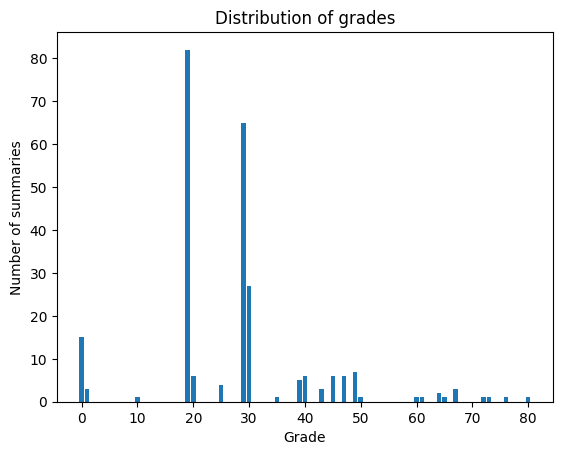

Statistics on the grades:
Mean grade: 27.384
Median grade: 29.0
Standard deviation: 14.26669894527745
Minimum grade: 0.0
Maximum grade: 80.0


In [7]:
# Plot an histogram of the grades
GRADES = test_data_['grade'].value_counts().sort_index()
plt.bar(GRADES.index, GRADES.values)
plt.xlabel('Grade')
plt.ylabel('Number of summaries')
plt.title('Distribution of grades')
plt.show()

# Print statistics on the grades
print('Statistics on the grades:')
print('Mean grade:', test_data_['grade'].mean())
print('Median grade:', test_data_['grade'].median())
print('Standard deviation:', test_data_['grade'].std())
print('Minimum grade:', test_data_['grade'].min())
print('Maximum grade:', test_data_['grade'].max())

In [8]:
# save the data
test_data_.to_csv("/Data/AxelDlv/LatinSummarizer/test_data_generated_finalmodel_beforefinetuning_withgrades.csv", index=False)